<a href="https://colab.research.google.com/github/ALAAOTB/Dust-detection-on-solar-panels-computer-vision/blob/main/Solar_panel_dust_detection_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Common
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

**Data info**

In [ ]:
# Class Names
root_path = '/content/drive/MyDrive/Sdaia-project - Copy/train/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 2 
Class Names : ['Clean', 'Dirty']


In [ ]:
# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

**Data Loading**

In [ ]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, validation_split=0.1)

# Load Data
train_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(224,224), shuffle=True, batch_size=32, subset='training')
valid_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(224,224), shuffle=True, batch_size=32, subset='validation')

Found 1627 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


**Data Visualization**

In [ ]:
def show_images(GRID=[5, 5], model=None, size=(20, 20), data=train_ds, test_data=None):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()

        plt.title(title)
        plt.axis('off')

        i+=1
        if i>=(n_images+1):
            break

    plt.tight_layout()
    plt.show()

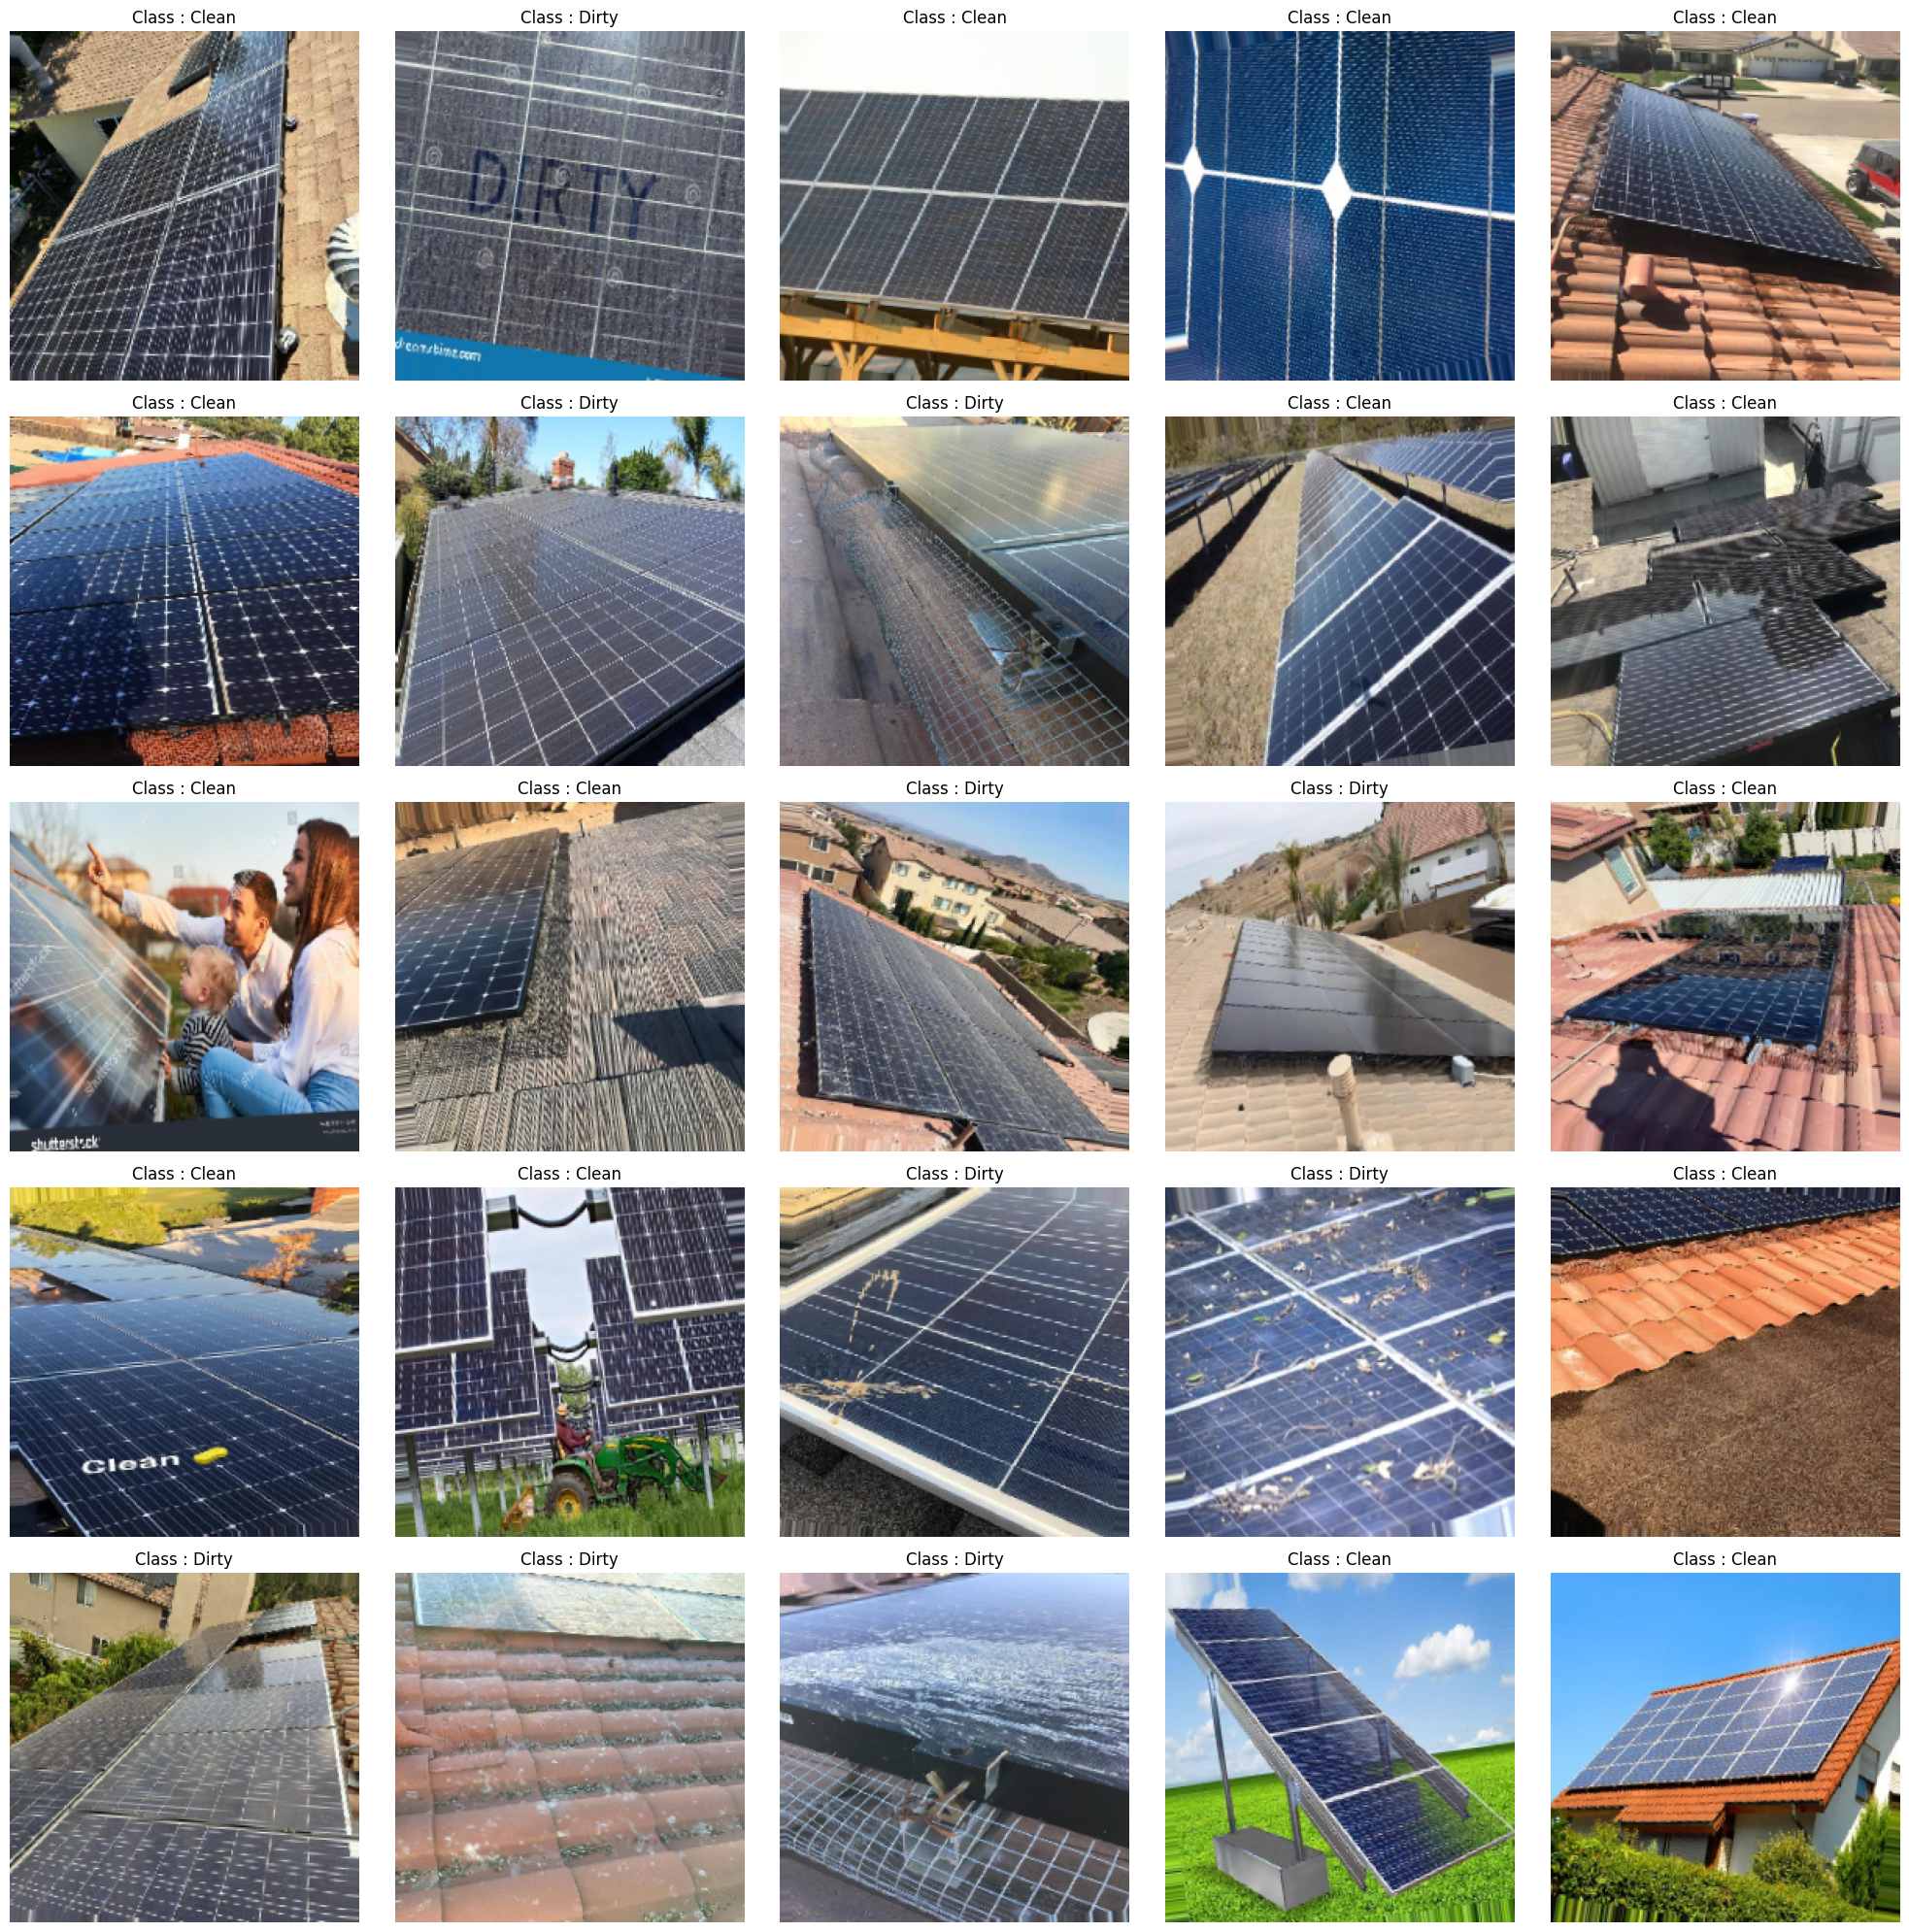

In [ ]:
show_images()

**Model**

In [ ]:
# Pre-Trained Model
base_model = ResNet50V2(input_shape=(224,224,3), include_top=False)
base_model.trainable = False

# Model Architecture
name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(224, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax')
], name=name)

# Callbacks
cbs = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

# Model Compiling
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
history = model.fit(train_ds, validation_data=valid_ds, callbacks=cbs, epochs=50)

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.6804

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



51/51 [==============================] - 320s 6s/step - loss: 0.7073 - accuracy: 0.6804 - val_loss: 0.5594 - val_accuracy: 0.7222
Epoch 2/50
51/51 [==============================] - 315s 6s/step - loss: 0.4692 - accuracy: 0.7677 - val_loss: 0.6535 - val_accuracy: 0.6944
Epoch 3/50
51/51 [==============================] - 301s 6s/step - loss: 0.3968 - accuracy: 0.8273 - val_loss: 0.6626 - val_accuracy: 0.7111
Epoch 4/50
51/51 [==============================] - 318s 6s/step - loss: 0.3210 - accuracy: 0.8648 - val_loss: 0.7489 - val_accuracy: 0.7500
Epoch 5/50
51/51 [==============================] - 311s 6s/step - loss: 0.2807 - accuracy: 0.8857 - val_loss: 0.8445 - val_accuracy: 0.7278
Epoch 6/50
51/51 [==============================] - 315s 6s/step - loss: 0.2538 - accuracy: 0.9004 - val_loss: 0.5944 - val_accuracy: 0.7444


**Testing**

In [ ]:
# # Visualize Predictions
# show_images(model=model, data=valid_ds)

In [ ]:
model = load_model("ResNet50V2.h5")

In [ ]:
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

In [ ]:
def classify_image(image_path, model):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions[0])
    return predicted_class

In [ ]:
def classify_images_in_folder(folder_path, model):
    class_names = ["Clean", "Dirty"]

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            actual_class = filename.split("_")[0]

            predicted_class = classify_image(image_path, model)
            predicted_class_name = class_names[predicted_class]

            print("Image:", filename)
            print("Actual class:", actual_class)
            print("Predicted class:", predicted_class_name)
            print()

In [ ]:
folder_path ="/content/drive/MyDrive/Sdaia-project - Copy/test"
classify_images_in_folder(folder_path, model)

1/1 [==============================] - 2s 2s/step
Image: clean_image1.jpg
Actual class: clean
Predicted class: Clean

1/1 [==============================] - 0s 272ms/step
Image: dirty_image3.jpg
Actual class: dirty
Predicted class: Dirty

1/1 [==============================] - 0s 173ms/step
Image: dirty_image2.jpg
Actual class: dirty
Predicted class: Dirty

1/1 [==============================] - 0s 180ms/step
Image: dirty_image1.jpg
Actual class: dirty
Predicted class: Dirty

1/1 [==============================] - 0s 184ms/step
Image: clean_image2.jpg
Actual class: clean
Predicted class: Clean

1/1 [==============================] - 0s 167ms/step
Image: clean_image3.jpg
Actual class: clean
Predicted class: Clean

1/1 [==============================] - 0s 170ms/step
Image: clean_image4.jpg
Actual class: clean
Predicted class: Clean

